## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")



MPS is enabled!
MPS is enabled!


### 1. Generate data from Archimedean spiral

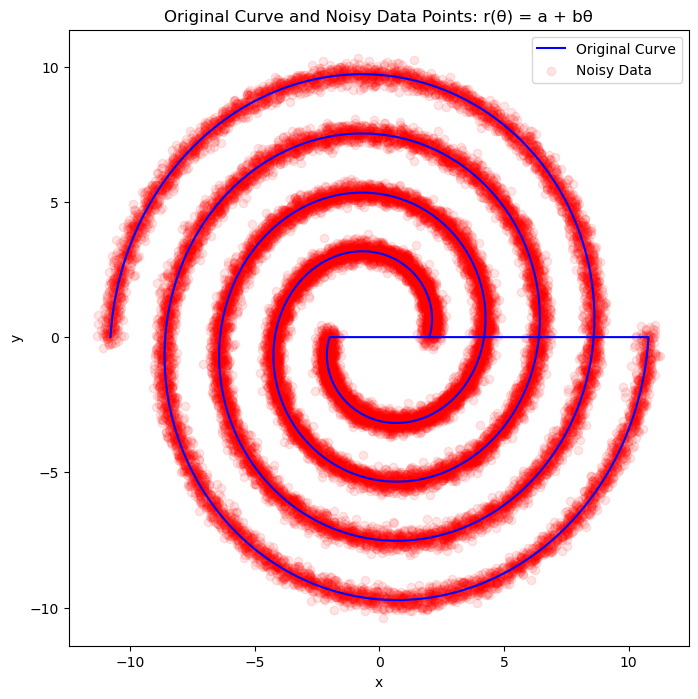

In [2]:
data = GenerateDataset()

## 2. Sparse coding

In [3]:
data_tensor = torch.tensor(data, dtype=torch.float,device = device)

# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=500, sparsity_level=0)


# Define optimizer for Biasis update
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 5000

# Training loop
for epoch in range(num_epochs):

    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

    if cost <= 1e-2:
        print('training ended!')
        break

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)



Epoch [10/5000], Cost = 0.24733443558216095
Epoch [20/5000], Cost = 0.18626321852207184
Epoch [30/5000], Cost = 0.1437171995639801
Epoch [40/5000], Cost = 0.11422918736934662
Epoch [50/5000], Cost = 0.09412461519241333
Epoch [60/5000], Cost = 0.08056219667196274
Epoch [70/5000], Cost = 0.07166440784931183
Epoch [80/5000], Cost = 0.06572462618350983
Epoch [90/5000], Cost = 0.06197340041399002
Epoch [100/5000], Cost = 0.05982605367898941
Epoch [110/5000], Cost = 0.058380503207445145
Epoch [120/5000], Cost = 0.05733143538236618
Epoch [130/5000], Cost = 0.056509919464588165
Epoch [140/5000], Cost = 0.05587529391050339
Epoch [150/5000], Cost = 0.05541272461414337
Epoch [160/5000], Cost = 0.05504795163869858
Epoch [170/5000], Cost = 0.054748937487602234
Epoch [180/5000], Cost = 0.054485853761434555
Epoch [190/5000], Cost = 0.054266899824142456
Epoch [200/5000], Cost = 0.054031819105148315
Epoch [210/5000], Cost = 0.053846318274736404
Epoch [220/5000], Cost = 0.05365332216024399
Epoch [230/50

### Plot learnt dictionary and clustered data points

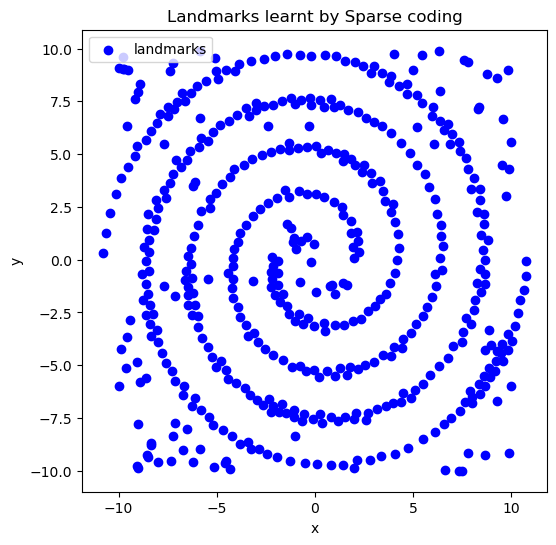

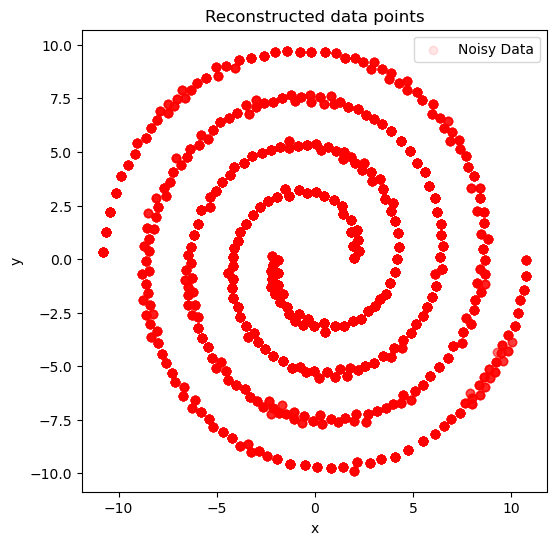

1.0


In [4]:

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[6, 6])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Reconstructed data points")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


## 2. Assign similarity (Define D)

### 2.1 K-nearest neighbours in dictionary (B)

In [5]:
## Compute K-nearest neighbors for each element in model.Basis

# Compute K-nearest neighbors
neighbors_indices = model.KNN(3).detach().cpu()
print("K-nearest neighbors indices:")
print(neighbors_indices)

K-nearest neighbors indices:
tensor([[236,   5, 482],
        [ 92,  51,  93],
        [287,  43, 124],
        ...,
        [490, 225, 408],
        [147, 499, 231],
        [498, 230, 147]])


torch.Size([3, 2])
torch.Size([3, 2])


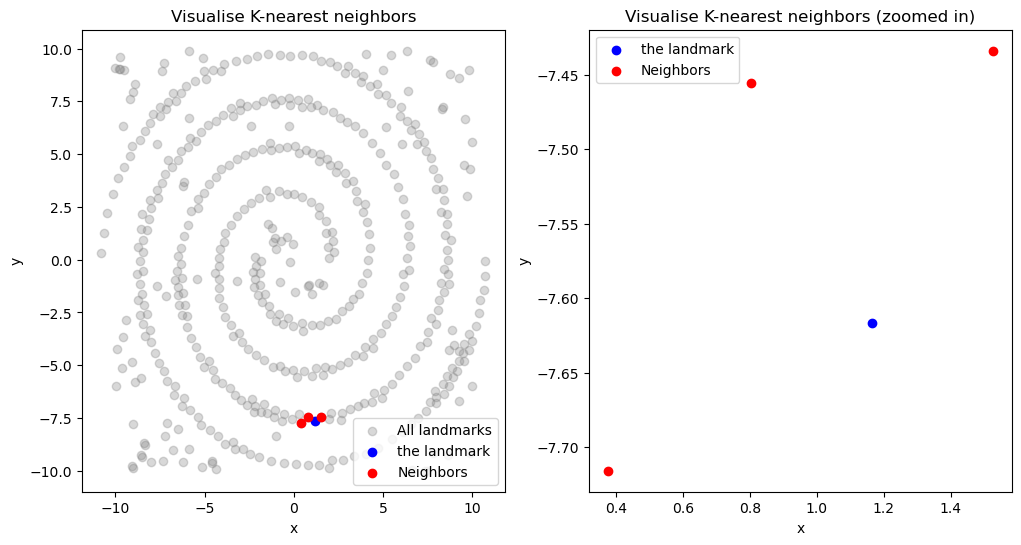

In [6]:
## plot neighbors for a landmark
idx = 200

fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

# plot dictionary elements
ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', color='gray', alpha=0.3)

ax.scatter(Bas[idx,0], Bas[idx,1], label='the landmark', color='blue', alpha=1)
neighbors = Bas[neighbors_indices[idx],:]
print(neighbors.shape)
ax.scatter(neighbors[:,0], neighbors[:,1], label='Neighbors', color='red', alpha=1)

# Setting the title and labels
ax.set_title("Visualise K-nearest neighbors")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

ax1.scatter(Bas[idx,0], Bas[idx,1], label='the landmark', color='blue', alpha=1)
neighbors = Bas[neighbors_indices[idx],:]
print(neighbors.shape)
ax1.scatter(neighbors[:,0], neighbors[:,1], label='Neighbors', color='red', alpha=1)

# Setting the title and labels
ax1.set_title("Visualise K-nearest neighbors (zoomed in)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
plt.show()


### 2.2 Construct D from B
Goal: minimising distance between neighbours


### !!Skipped due to dimension issue!!

In [7]:
# a = torch.zeros(7,4,7)
# b = torch.zeros(7,5)

# print((a@b@b.T@a.T).shape)
# # print(a.shape)
# # print(((a@a).shape))

Goal: keep topology by using interpolation (LLE on dictionary elements)

In [8]:
## Weight matrix

Basis = model.Basis.detach()

neighbors = Basis[neighbors_indices,:] # (700,k,2)

print('neighbors shape: ', neighbors.shape)

local_cov = (Basis.unsqueeze(1)-neighbors) @ torch.transpose((Basis.unsqueeze(1)-neighbors), dim0=1, dim1=2) # (700,k,k)=(700,k,2)@(700,2,k)
local_cov_inv = torch.inverse(local_cov) # (700,k,k)

print(local_cov[1]@local_cov_inv[1])
weight = torch.sum(local_cov_inv,dim=1) / torch.sum(local_cov_inv,dim=[1,2]).unsqueeze(1) #(700,k)

print('weight: ', weight.unsqueeze(-1).shape)
recon_landmark = torch.transpose(neighbors,dim0=1,dim1=2) @ weight.unsqueeze(-1) # (700,2,k) @ (700,k,1)
recon_landmark.squeeze_(2)
print(recon_landmark.shape)
print('interpolation error: ')
print(recon_landmark - Basis)

# check sum of weight
print(torch.sum(weight,dim=1))


neighbors shape:  torch.Size([500, 3, 2])
tensor([[ 0.9998,  0.0758,  0.1400],
        [-0.0052,  1.0710,  0.1880],
        [-0.0318,  0.1102,  1.2480]], device='mps:0')
weight:  torch.Size([500, 3, 1])
torch.Size([500, 2])
interpolation error: 
tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-9.5367e-07,  2.3842e-07],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-4.7684e-07,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-1.4901e-08, -4.7684e-07],
        [ 0.0000e+00,  4.7684e-07],
        [-4.7684e-07,  4.7684e-07],
        [ 0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00],
        [-2.3842e-07,  0.0000e+00],
        [-4.7684e-07, -4.7684e-07],
        [-2.3842e-07,  0.0000e+00],
        [-3.8147e-06,  5.7220e-06],
        [-4.7684e-07,  0.0000e+00]

torch.Size([500, 3])
torch.Size([500, 3])
tensor([0., 0.])


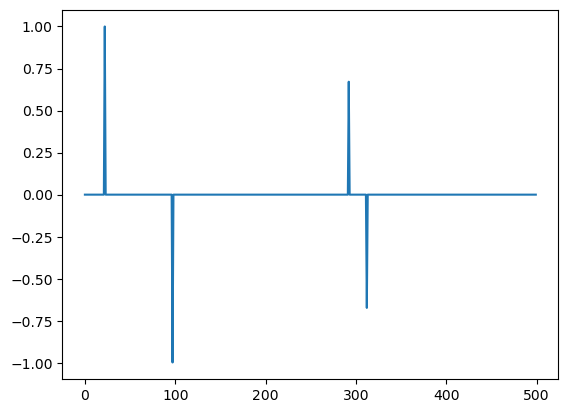

In [9]:
print(neighbors_indices.shape)
print(weight.shape)
Diff = torch.eye(Basis.shape[0],Basis.shape[0], device=device)

# Iterate over each row (each landmark)
for i in range(neighbors_indices.size(0)):
    # Select vaelements from Diff based on indices and apply weights
    Diff[i, neighbors_indices[i]] -= weight[i]


# Validation 
diff = Diff.cpu()[22]
plt.plot(diff)
print(Bas.T @ diff)

### 2.3 Solve generalised eigenvalue proble

In [10]:
Diff = Diff.cpu()

d = 10 # dimension of final embedding space


/var/folders/tr/k4p6cxld3ql638sby8p0sr500000gn/T/ipykernel_94699/3375265273.py:3: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1704987089515/work/aten/src/ATen/native/Copy.cpp:301.)
  Diff_eigenvalues = Diff_eigenvalues.to(torch.float32)


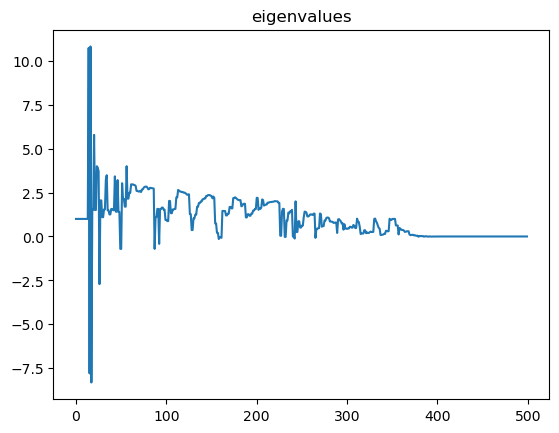

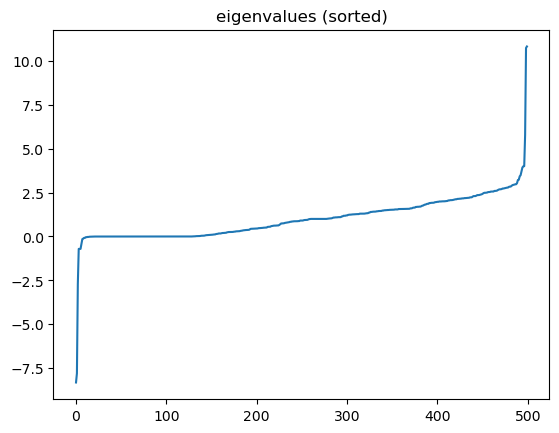

tensor(499.9999)


In [11]:
Diff_eigenvalues, Diff_eigenvectors = torch.linalg.eig(Diff)

Diff_eigenvalues = Diff_eigenvalues.to(torch.float32)
Diff_eigenvectors = Diff_eigenvectors.to(torch.float32)

plt.figure()
plt.plot(Diff_eigenvalues)
plt.title('eigenvalues')
plt.show()


sorted_indices = torch.argsort(Diff_eigenvalues)
sorted_eigenvalues = Diff_eigenvalues[sorted_indices]
sorted_eigenvectors = Diff_eigenvectors[:, sorted_indices]

plt.figure()
plt.plot(sorted_eigenvalues)
plt.title('eigenvalues (sorted)')
plt.show()


print(torch.sum(sorted_eigenvalues)) ## TODO: Why????????????

In [12]:
## Now find P

A = model.Activ.detach().cpu()

#  Compute eigenvalue decomposition of A
ATA_eigenvalues,ATA_eigenvectors = torch.linalg.eigh(A.T@A)

# Square root of eigenvalues
ATA_sqrt_eigenvalues = torch.sqrt(ATA_eigenvalues)

# Reconstruct square root of A from eigenvalues and eigenvectors
sqrt_ATA = ATA_eigenvectors @ torch.diag(ATA_sqrt_eigenvalues) @ ATA_eigenvectors.t()
inv_sqrt_ATA = torch.pinverse(sqrt_ATA)

raw_P = inv_sqrt_ATA @ sorted_eigenvectors[:,0:d]

# Normalize each column 
raw_P = raw_P / torch.norm(raw_P, dim=0) 


P = raw_P.T @ inv_sqrt_ATA / inv_sqrt_ATA.size(0)**0.5
print(P.shape)

print(P)

torch.Size([10, 500])
tensor([[-9.4462e-12, -6.8728e-13, -5.7181e+01,  ..., -2.3416e-18,
          3.2109e-11, -7.0743e-12],
        [ 1.8310e-18,  2.1001e-13, -9.4316e-05,  ..., -2.7829e-22,
         -1.5970e-13, -2.3909e-13],
        [-1.0509e-12,  3.4762e-13, -6.6616e+00,  ...,  1.6102e-17,
         -5.2070e-12,  6.9361e-13],
        ...,
        [ 1.7872e-15,  4.7791e-15,  1.5979e-02,  ..., -3.0367e-16,
         -7.7478e-15, -2.7281e-15],
        [ 2.3088e-16,  1.3589e-16, -1.6870e-03,  ...,  1.3995e-12,
         -7.1877e-10, -3.9837e-10],
        [ 5.5720e-15,  2.2269e-15,  5.1554e-01,  ...,  2.1253e-11,
         -1.6618e-09, -1.1306e-09]])


### 2.4 Visualise P

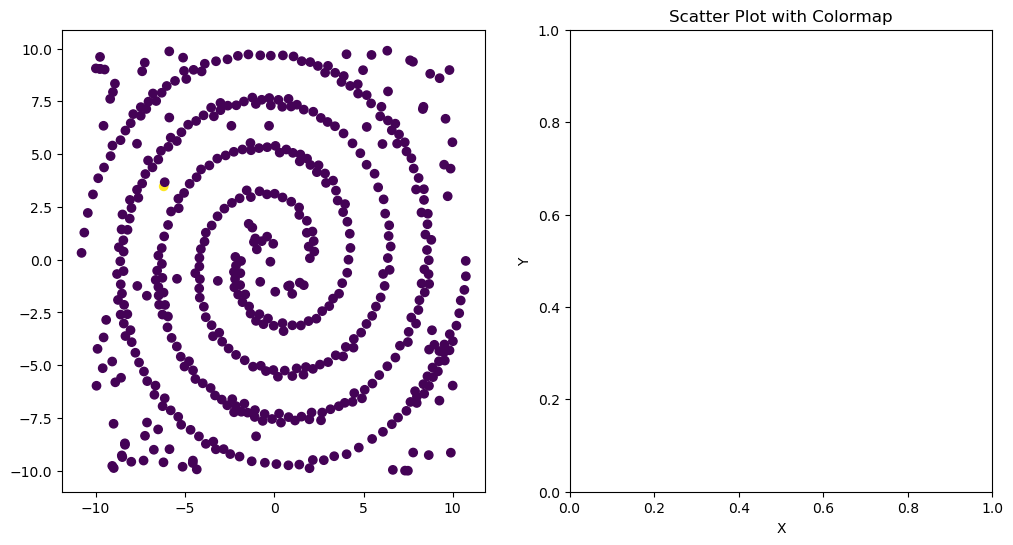

In [13]:
# Example data
idx = 3
fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

colors = P.cpu()[idx]
colors = (colors - torch.min(colors)) / (torch.max(colors) - torch.min(colors))

cmap = 'viridis'  # Example colormap

# plot dictionary elements using first row of P
ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=colors, cmap=cmap)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Colormap')
plt.show()

### 2.5 Embedding space distance visualization

torch.Size([500, 1])
tensor([[2.1769e-09],
        [2.1771e-09],
        [1.8401e+02],
        [2.1770e-09],
        [2.1769e-09],
        [2.1769e-09],
        [2.1769e-09],
        [1.3452e+02],
        [2.1769e-09],
        [2.1769e-09],
        [6.4257e+00],
        [2.1770e-09],
        [2.4201e-09],
        [2.1769e-09],
        [2.2142e-09],
        [2.1967e-09],
        [4.8663e-08],
        [2.1217e-09],
        [4.6130e-07],
        [6.5312e+04],
        [2.1732e-09],
        [2.1756e-09],
        [2.1800e-09],
        [4.6418e+03],
        [2.1765e-09],
        [1.3920e+04],
        [2.5201e-09],
        [2.1890e-09],
        [2.1780e-09],
        [2.1748e-09],
        [2.1737e-09],
        [2.1794e-09],
        [2.1898e-09],
        [2.4326e-09],
        [2.1760e-09],
        [2.8940e-05],
        [2.2588e-09],
        [6.8250e+02],
        [1.7251e+02],
        [1.3534e+02],
        [2.1775e-09],
        [4.2633e-09],
        [2.1770e-09],
        [1.0503e+02],
        [4.

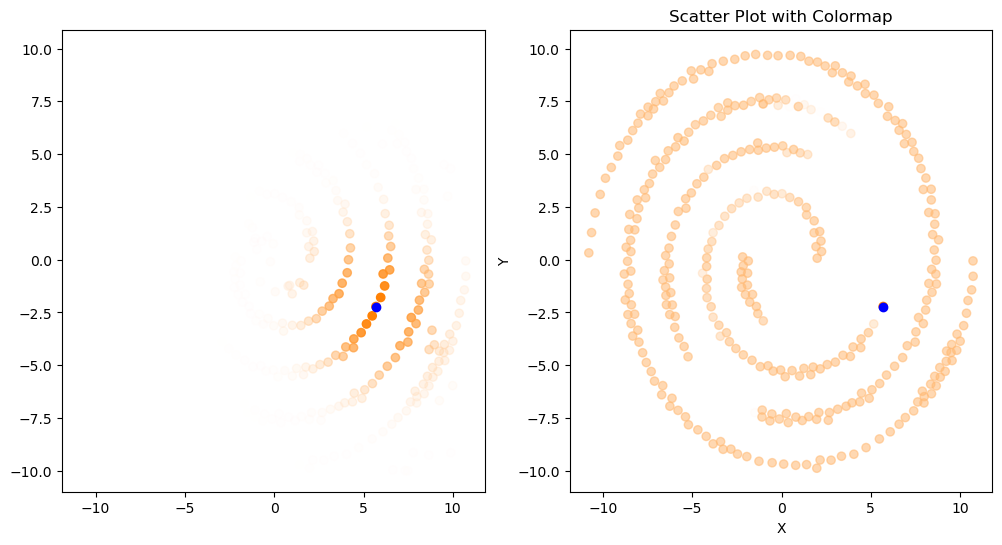

In [23]:
landmark_idx = 61
orig_sigma = 3
embed_sigma = 2e-9

def gaussian(dist, sigma):
    return torch.exp(-torch.pow(dist, 2) / (2 * sigma**2))

## Euc distance
orig_dist = torch.cdist(Bas,Bas[landmark_idx,:].unsqueeze(0),p=2)
Gaussian_orig_dist = gaussian(orig_dist,sigma=orig_sigma)
print(orig_dist.shape)

## Embedding space dist
embed_dist = torch.cdist(P.T,P.T[landmark_idx,:].unsqueeze(0),p=2)
print(embed_dist)
Gaussian_embed_dist = gaussian(embed_dist,sigma=embed_sigma)

fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

map = [(1, 1, 1, 0), (1, 0.5, 0, 1)]  # Start with transparent (white) and end with orange
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', map)

# plot dictionary elements using first row of P


ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=Gaussian_orig_dist, cmap=cmap,vmin=1e-2, vmax=1)
ax1.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=Gaussian_embed_dist, cmap=cmap,vmin=1e-2, vmax=1)

ax.scatter(Bas[landmark_idx, 0], Bas[landmark_idx, 1], label='the landmark', c='blue')
ax1.scatter(Bas[landmark_idx, 0], Bas[landmark_idx, 1], label='the landmark', c='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Colormap')
plt.show()
